<a href="https://colab.research.google.com/github/lvidak/PzAP_projekt/blob/main/Projekt_PzAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Programiranje za zanalizu podataka - Projekt
##Analiza vremenskih podataka i potrošnje vode
###Luka Vidak

Projekt analizira potrošnju vode u odnosu na vremenske uvjete. Podaci iz CSV skupa integriraju se s vremenskim podacima iz API-ja. Nakon pohrane u bazu provodi se analiza sezonalnosti i jednostavne vizualizacije. Kako se potrošnja vode mijenja kroz vrijeme i ima li veze s vremenskim uvjetima (temperatura, oborine)?

Izvori:
* Kaggle – Water Consumption Dataset (CSV) : https://www.kaggle.com/datasets/atharvasoundankar/global-water-consumption-dataset-2000-2024
* Open-Meteo API – vremenski podaci (JSON) : https://open-meteo.com/

## 1. Uvod
Voda je jedan od ključnih prirodnih resursa, a njezina dostupnost i potrošnja sve su važnije teme u kontekstu klimatskih promjena, rasta stanovništva i industrijskog razvoja. Promjene u temperaturi i količini oborina izravno i neizravno utječu na obrasce potrošnje vode, osobito u sektorima poput poljoprivrede, energetike i kućanstava.
Motivacija za ovaj projekt proizlazi iz potrebe da se ispita postoji li povezanost između potrošnje vode i vremenskih uvjeta, konkretno prosječne temperature zraka i količine oborina.

Cilj projekta je analizirati kako se potrošnja vode mijenja kroz vrijeme
te postoji li povezanost s vremenskim uvjetima poput temperature i oborina.U projektu se koriste dva heterogena izvora podataka:
- CSV skup podataka o globalnoj potrošnji vode (Kaggle)
- JSON vremenski podaci dobiveni putem Open-Meteo API-ja

Podaci se pretprocesiraju, integriraju, pohranjuju u bazu podataka,
te se nad njima provodi bazična analiza i vizualizacija.


##2. Opis implementacije

U projektu se koriste dva međusobno heterogena skupa podataka:

1. Podaci o potrošnji vode (CSV format)
Skup podataka preuzet je s platforme Kaggle i sadrži godišnje podatke o potrošnji vode za 20 odabranih zemalja u razdoblju od 2000. do 2024. godine.
Ključni korišteni atribut je:

-Total Water Consumption (Billion Cubic Meters) – ukupna godišnja potrošnja vode izražena u milijardama kubičnih metara.

2. Vremenski podaci (JSON format)
Vremenski podaci dohvaćaju se korištenjem Open-Meteo Archive API-ja, koji omogućuje pristup povijesnim meteorološkim podacima. Za svaku godinu dohvaćeni su:

-prosječna godišnja temperatura zraka (°C),

-ukupna godišnja količina oborina (mm).

Ovi izvori su heterogeni prema formatu (CSV i JSON) i načinu pristupa (lokalna datoteka i web API), čime se ispunjava jedan od temeljnih uvjeta projektnog zadatka.

###2.1. Prikupljanje podataka




In [84]:
#Učitavanje biblioteka
import pandas as pd
import numpy as np
import requests
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


2.1.1. Podaci o potrošnji vode (CSV)

Podaci o potrošnji vode preuzeti su s Kaggle platforme [1]. Skup podataka sadrži godišnje podatke o potrošnji vode za odabrane države u razdoblju od 2000. do 2024. godine. Podaci su pohranjeni u CSV formatu, što omogućuje jednostavno učitavanje i obradu pomoću biblioteke pandas.

In [85]:
# Učitavanje CSV datoteke
df_water = pd.read_csv("cleaned_global_water_consumption.csv")

# Pregled podataka
df_water.head()


,Country,Year,Total Water Consumption (Billion Cubic Meters),Per Capita Water Use (Liters per Day),Agricultural Water Use (%),Industrial Water Use (%),Household Water Use (%),Rainfall Impact (Annual Precipitation in mm),Groundwater Depletion Rate (%),Water Scarcity Level
0,Argentina,2000,481.490000,235.431429,48.550000,20.844286,30.100000,1288.698571,3.255714,Moderate
1,Argentina,2001,455.063000,299.551000,48.465000,26.943000,22.550000,1371.729000,3.120000,Moderate
2,Argentina,2002,482.749231,340.124615,50.375385,29.042308,23.349231,1590.305385,2.733846,Moderate
3,Argentina,2003,452.660000,326.756667,49.086667,30.476000,24.440000,1816.012667,2.708000,Moderate
4,Argentina,2004,634.566000,230.346000,38.670000,36.670000,23.924000,815.998000,1.902000,Moderate


Ovdje se CSV datoteka učitava u DataFrame strukturu, koja omogućuje daljnju analizu i manipulaciju podacima.

In [86]:
df_water.columns #prikaz stupaca CSV dataFrame-a kojeg smo učitali

Index(['Country', 'Year', 'Total Water Consumption (Billion Cubic Meters)',
       'Per Capita Water Use (Liters per Day)', 'Agricultural Water Use (%)',
       'Industrial Water Use (%)', 'Household Water Use (%)',
       'Rainfall Impact (Annual Precipitation in mm)',
       'Groundwater Depletion Rate (%)', 'Water Scarcity Level'],
      dtype='object')

In [87]:
df_water.info() #prikaz informacija o podatcima koje sadrži CSV dataFrame-a kojeg smo učitali

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Country                                         500 non-null    object 
 1   Year                                            500 non-null    int64  
 2   Total Water Consumption (Billion Cubic Meters)  500 non-null    float64
 3   Per Capita Water Use (Liters per Day)           500 non-null    float64
 4   Agricultural Water Use (%)                      500 non-null    float64
 5   Industrial Water Use (%)                        500 non-null    float64
 6   Household Water Use (%)                         500 non-null    float64
 7   Rainfall Impact (Annual Precipitation in mm)    500 non-null    float64
 8   Groundwater Depletion Rate (%)                  500 non-null    float64
 9   Water Scarcity Level                       

2.1.2. Pretprocesiranje podataka o potrošnji vode (globalna godišnja potrošnja)

U ovom dijelu projekta provodi se agregacija podataka o potrošnji vode s ciljem dobivanja globalne godišnje potrošnje vode. Izvorni skup podataka sadrži zapise po državama i godinama, što znači da za svaku godinu postoji više redaka – po jedan za svaku državu. Takva struktura podataka nije pogodna za izravnu usporedbu s vremenskim podacima, koji su u ovom projektu prikupljeni na godišnjoj razini. Kako bi se omogućila daljnja integracija podataka i vremenska analiza, potrebno je potrošnju vode svesti na istu vremensku razinu, odnosno na jedan zapis po godini.

Agregacija se provodi grupiranjem podataka prema godini te zbrajanjem ukupne potrošnje vode svih država unutar iste godine. Time se dobiva globalna godišnja potrošnja vode, izražena u milijardama kubičnih metara.

Rezultat agregacije sprema se u novi DataFrame koji sadrži samo dvije varijable: godinu i ukupnu globalnu potrošnju vode.

Kako bi analiza bila logički konzistentna, podaci su filtrirani na jednu odabranu državu. Time se osigurava da su podaci o potrošnji vode i vremenski podaci međusobno usporedivi.

In [88]:
df_global = ( #definicija novog DataFrame-a u kojeg spremamo agregirane podatke
    df_water
    .groupby("Year", as_index=False)["Total Water Consumption (Billion Cubic Meters)"].sum())
#grupiramo podatke prema stupcu Year (osiguravamo da nije index) te odabiremo s kojim stupcem ćemo agregirati podatke

df_global.head(20)

,Year,Total Water Consumption (Billion Cubic Meters)
0,2000,10090.381994
1,2001,10061.071938
2,2002,9498.114951
3,2003,10186.875738
4,2004,10901.926143
5,2005,9124.758543
6,2006,9852.581137
7,2007,10351.435882
8,2008,11062.775785
9,2009,9397.981049


2.1.3. Dohvaćanje vremenskih podataka (Open-Meteo API - JSON)

U ovom dijelu provodimo dohvaćanje i obradu vremenskih podataka korištenjem javno dostupnog Open-Meteo API-ja [2] koji omogućuje pristup povijesnim meteorološkim podacima u JSON formatu. Za svaku godinu dohvaćaju se:

* prosječna dnevna temperatura zraka (°C),
* ukupna količina oborina (mm).

Cilj ovog koraka je dobiti vremenske varijable koje potencijalno utječu na potrošnju vode, konkretno prosječnu temperaturu zraka i ukupnu količinu oborina.

Budući da se analiza potrošnje vode provodi na godišnjoj razini, vremenski podatci se također agregiraju na godišnju razinu da se osigura vremenska usklađenost između različitih skupova podataka. Dohvaćanje podataka implementirano je funkcijom get_weather_data, koja šalje HTTP GET zahtjev prema API-ju te obrađuje odgovor.

In [89]:
def get_weather_data(year, latitude, longitude):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": f"{year}-01-01",
        "end_date": f"{year}-12-31",
        "daily": "temperature_2m_mean,precipitation_sum",
        "timezone": "UTC"
    }

    try:
        response = requests.get(url, params=params, timeout=30)
        response.raise_for_status()
        data = response.json()

        daily = data.get("daily", {})
        temps = daily.get("temperature_2m_mean", None)
        precs = daily.get("precipitation_sum", None)

        if temps is None or precs is None:

            return np.nan, np.nan


        temp_avg = np.nanmean(np.array(temps, dtype=float))
        precip_sum = np.nansum(np.array(precs, dtype=float))

        return float(temp_avg), float(precip_sum)

    except (requests.RequestException, ValueError, KeyError) as e:
        print(f"[WARN] Open-Meteo fail za {year} ({latitude},{longitude}): {e}")
        return np.nan, np.nan


U funkciji se koristi:

-error handling (try/except) kako bi se spriječio prekid programa u slučaju mrežnih ili API pogrešaka,

-np.nanmean i np.nansum kako bi se sigurno obradile eventualne nedostajuće vrijednosti.


In [90]:
weather_data = []

# Definiramo globalne koordinate za dohvaćanje vremenskih podataka
latitude = 48.0  # Primjer geografske širine
longitude = 16.0 # Primjer geografske dužine

for year in df_global["Year"]:
    temp, precip = get_weather_data(year, latitude, longitude)
    weather_data.append([year, temp, precip])

df_weather = pd.DataFrame(
    weather_data,
    columns=["Year", "Avg_Temperature", "Total_Precipitation"]
)

df_weather.head(20)

,Year,Avg_Temperature,Total_Precipitation
0,2000,8.940984,726.9
1,2001,7.788767,803.4
2,2002,8.634521,984.3
3,2003,8.199178,647.8
4,2004,7.431694,870.8
5,2005,7.169315,1020.9
6,2006,7.936712,889.4
7,2007,8.735616,968.6
8,2008,8.642623,920.0
9,2009,8.203836,1102.7


Open-Meteo API omogućuje dohvaćanje povjesnih meteoroloških podataka u JSON formatu, što je heterogen izvor podataka u odnosu na CSV skup koji sadrži podatke o potrošnji vode.



###2.2. Integracija podataka

Provodimo integraciju prethodno obrađenih skupova podataka, odnosno godišnje potrošnje vode i godišnje vremenske podatke. Spajamo podatke po stupcu "Year", koji predstavlja zajednički ključ između oba skupa podataka.

Sve daljnje analize radimo prema tom spojenom skupu podataka.

In [91]:
df_merged = pd.merge(df_global, df_weather, on="Year")
df_merged.head(15) #samo godine koje postoje u oba skupa će biti uključene u rezultat

,Year,Total Water Consumption (Billion Cubic Meters),Avg_Temperature,Total_Precipitation
0,2000,10090.381994,8.940984,726.9
1,2001,10061.071938,7.788767,803.4
2,2002,9498.114951,8.634521,984.3
3,2003,10186.875738,8.199178,647.8
4,2004,10901.926143,7.431694,870.8
5,2005,9124.758543,7.169315,1020.9
6,2006,9852.581137,7.936712,889.4
7,2007,10351.435882,8.735616,968.6
8,2008,11062.775785,8.642623,920.0
9,2009,9397.981049,8.203836,1102.7


Time se dobiva jedinstveni skup podataka koji sadrži potrošnju vode, prosječnu temperaturu i ukupne oborine za svaku godinu.

###2.3. Pohrana podataka u bazu

Integrirani skup podataka pohranjujemo u relacijsku bazu podataka. Kao sustav za pohranu koristim SQLite. Podatke pohranjujemo u bazu kako bi imali trajno pohranjen skup podataka. Kasnije možemo pristupiti podatcima putem REST API-ja.

In [92]:
import sqlite3

with sqlite3.connect("water_weather.db") as conn:
    df_merged.to_sql(
        "water_weather",
        conn,
        if_exists="replace",
        index=False
    )

    cursor = conn.cursor()
    cursor.execute("""
        SELECT Year, Avg_Temperature, Total_Precipitation
        FROM water_weather
        ORDER BY Year DESC
        LIMIT 5
    """)

    print("Zadnjih 5 zapisa iz baze:")
    for row in cursor.fetchall():
        print(row)


Zadnjih 5 zapisa iz baze:
(2024, 10.591530054644808, 896.2)
(2023, 10.056986301369864, 962.1)
(2022, 9.62931506849315, 813.3)
(2021, 8.60054794520548, 809.7)
(2020, 9.359562841530055, 991.6)


###2.4. Analiza i vizualizacija podataka

2.4.1. Trend potrošnje vode

Za analizu promjena potrošnje kroz vrijeme koristi se linijski graf. Linijski graf je odabran jer je najprikladniji za prikaz vremenskih serija i omogućuje jednostavno uočavanje dugoročnih trendova.

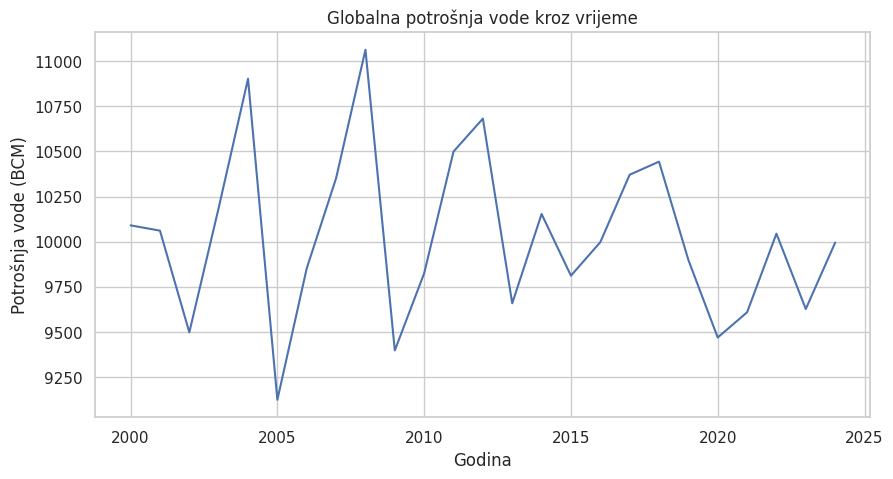

In [93]:
plt.figure(figsize=(10,5))
plt.plot(df_merged["Year"], df_merged["Total Water Consumption (Billion Cubic Meters)"])
plt.title("Globalna potrošnja vode kroz vrijeme")
plt.xlabel("Godina")
plt.ylabel("Potrošnja vode (BCM)")
plt.show()


2.4.2. Utjecaj temperature i oborina

Za analizu odnosa između potrošnje vode i vremenskih varijabli koriste se scatter dijagrami. Scatter dijagrami omogućuju vizualnu procjenu postoji li linearna ili nelinearna povezanost između varijabli.

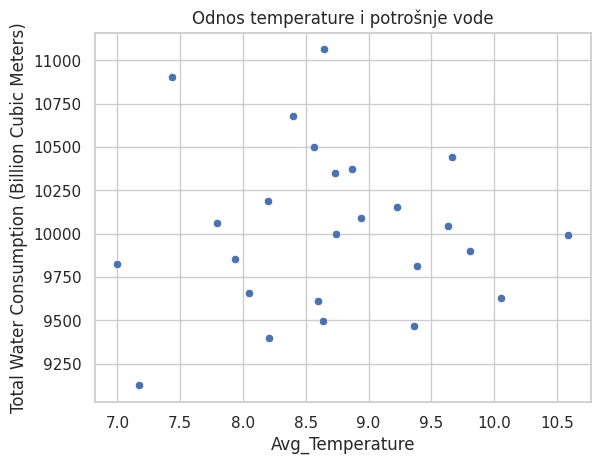

In [94]:
sns.scatterplot(
    data=df_merged,
    x="Avg_Temperature",
    y="Total Water Consumption (Billion Cubic Meters)"
)
plt.title("Odnos temperature i potrošnje vode")
plt.show()


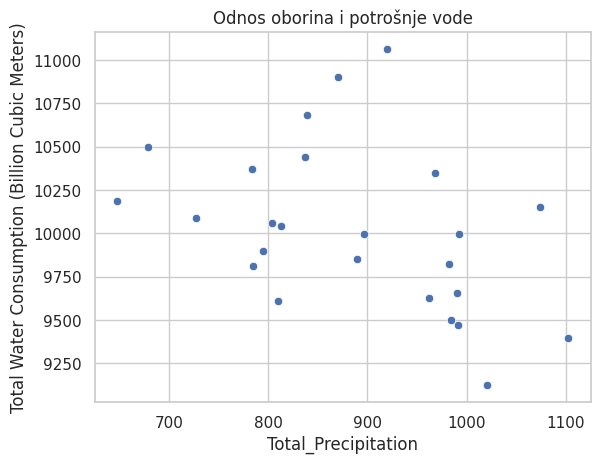

In [95]:
sns.scatterplot(
    data=df_merged,
    x="Total_Precipitation",
    y="Total Water Consumption (Billion Cubic Meters)"
)
plt.title("Odnos oborina i potrošnje vode")
plt.show()


2.4.3. Korelacijska i regresijska analiza

Korelacijska matrica izračunata je pomoću metode .corr(), dok je za kvantifikaciju odnosa korišten linearni regresijski model:

In [96]:
df_merged[[
    "Total Water Consumption (Billion Cubic Meters)",
    "Avg_Temperature",
    "Total_Precipitation"
]].corr()


,Total Water Consumption (Billion Cubic Meters),Avg_Temperature,Total_Precipitation
Total Water Consumption (Billion Cubic Meters),1.000000,0.024938,-0.413049
Avg_Temperature,0.024938,1.000000,-0.130843
Total_Precipitation,-0.413049,-0.130843,1.000000


Provjeravamo ima li nedostajućih vrijednosti

In [97]:
df_merged.isnull().sum()

,0
Year,0
Total Water Consumption (Billion Cubic Meters),0
Avg_Temperature,0
Total_Precipitation,0


2.4.4. Sezonalna analiza

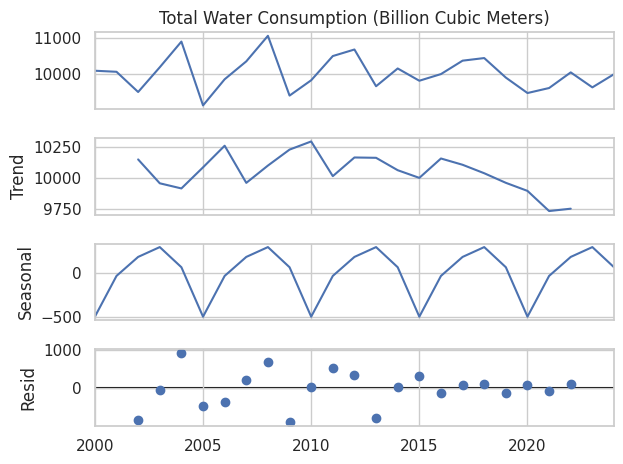

In [98]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(
    df_merged.set_index("Year")["Total Water Consumption (Billion Cubic Meters)"],
    model="additive",
    period=5
)

result.plot()
plt.show()


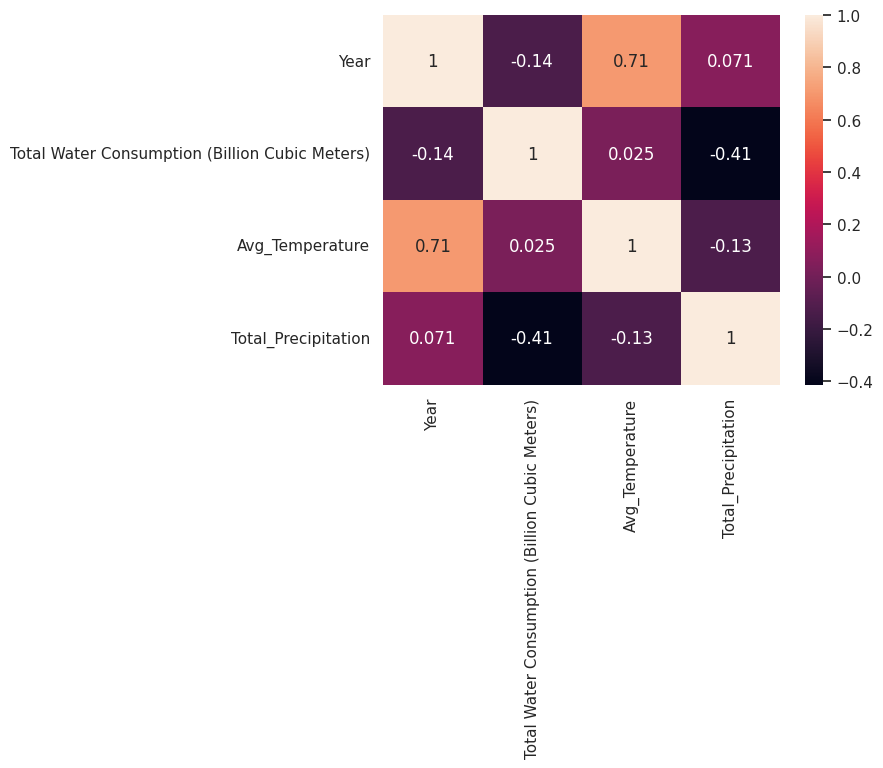

In [99]:
sns.heatmap(df_merged.corr(), annot=True)
plt.show()

2.4.5. Linearni regresijski model

In [100]:
from sklearn.linear_model import LinearRegression

X = df_merged[["Avg_Temperature", "Total_Precipitation"]]
y = df_merged["Total Water Consumption (Billion Cubic Meters)"]

model = LinearRegression()
model.fit(X, y)

model.score(X, y)


0.17147107932576078

Koristimo linearni regresijski model kako bi procjenili utjecaj vremenskih uvjeta na potrošnju vode. Dok su prethodne analize pružile vizualan uvid odnosa između varijabli, regresijski model omogućuje formalno modeliranje tih odnosa i njigovu numeričku virjednost.

Rezultat modela izražava se pomoću koeficjenta detemrinacije (R^2), koji pokazuje koliki dio varijabilnosti potrošnje vode može biti objašnjen korištenim varijablama.

Vrijednost R^2 blizu 1 označava snažnu povezanost, dok vrijednost blizu 0 upućuje na slab ili nikakav linearni odnos. Kako možemo primjetiti R^2 iznosi nam 0.17 odnosno 17% što nam ukazuje na znatno slabi linearni odnos među varijablama.

###2.5. Izrada REST-API-ja (Flask)

API omogućuje:

* dohvat svih integriranih podataka,
* dohvat podataka za pojedinu godinu.
Server se pokreće u zasebnoj niti kako bi se omogućio nastavak izvođenja ostatka programa.

Flask rest API implementiran je za pristup integriranim podatcima. Budući da se projekt razvija u Collab okruženju, web server se pokreće u zasebnom dretvenom procesu (thread) kako bi se izbjeglo blokiranje glavnog programa. Server sluša HTTP zahtjeve na portu 8000 i omogućuje dohvat cjelokupnih podataka ili filtriranih rezultata putem REST endpoint-a

In [101]:
from flask import Flask, jsonify
import threading

# Inicijalizacija Flask aplikacije
app = Flask(__name__)

# RUTA 1: Dohvat svih integriranih podataka
@app.route('/api/water', methods=['GET'])
def get_all_data():
    return jsonify(df_merged.to_dict(orient='records'))

# RUTA 2: Dohvat podataka za određenu godinu
@app.route('/api/water/<int:year>', methods=['GET'])
def get_by_year(year):
    filtered = df_merged[df_merged["Year"] == year]
    return jsonify(filtered.to_dict(orient='records'))

# Funkcija za pokretanje Flask servera
def run_server():
    app.run(port=8000)

# Pokretanje servera u pozadini (thread)
t = threading.Thread(target=run_server)
t.start()

print("Flask REST API za potrošnju vode pokrenut na portu 8000.")


 * Serving Flask app '__main__'
Flask REST API za potrošnju vode pokrenut na portu 8000.
 * Debug mode: off


Address already in use
Port 8000 is in use by another program. Either identify and stop that program, or start the server with a different port.


## Zaključak

Cilj ovog projekta bio je analizirati promjene globalne potrošnje vode kroz vrijeme te ispitati postoji li povezanost između potrošnje vode i vremenskih uvjeta, konkretno prosječne godišnje temperature i ukupne količine oborina. U tu svrhu korištena su dva heterogena izvora podataka: povijesni skup podataka o globalnoj potrošnji vode u CSV formatu te vremenski podaci dohvaćeni putem Open-Meteo API-ja u JSON formatu. Nakon prikupljanja, podaci su pretprocesirani, integrirani, pohranjeni u bazu podataka i analizirani pomoću statističkih metoda i vizualizacija.

Analiza vremenskog trenda pokazala je da globalna potrošnja vode kroz promatrano razdoblje pokazuje umjerene fluktuacije, ali i opći dugoročni rast, što se može povezati s rastom populacije, industrijalizacijom i povećanim poljoprivrednim potrebama. Sezonalna dekompozicija dodatno je istaknula postojanje dugoročnog trenda, dok sezonska komponenta nije izrazito dominantna zbog agregiranih godišnjih podataka.

Vizualizacije odnosa između prosječne temperature i potrošnje vode pokazale su blagu pozitivnu tendenciju, pri višim temperaturama često se bilježi veća potrošnja vode. Međutim, raspršenost podataka ukazuje da taj odnos nije snažno linearan. Slično tome, analiza odnosa između ukupnih oborina i potrošnje vode ne pokazuje jasan i konzistentan obrazac, iako se u nekim godinama s manjom količinom oborina bilježi povećana potrošnja, što može upućivati na povećanu potrebu za navodnjavanjem.

Regresijska analiza dodatno potvrđuje ove zaključke. Dobivena vrijednost koeficijenta determinacije R^2 = 0.17 pokazuje da prosječna temperatura i količina oborina zajedno iznose oko 17% varijabilnosti globalne potrošnje vode. To upućuje na zaključak da vremenski uvjeti imaju određen, ali relativno slab utjecaj na ukupnu potrošnju vode, dok značajan dio varijacija proizlazi iz drugih čimbenika poput demografskih, ekonomskih, tehnoloških i političkih utjecaja.

Na samom kraju, projekt je pokazao da postoji povezanost između vremenskih uvjeta i potrošnje vode, ali ona nije dominantna. Najveća vrijednost projekta leži u demonstraciji cjelovitog procesa rada s podacima, od prikupljanja i integracije heterogenih izvora, preko analize i vizualizacije, do pohrane podataka i izrade REST API-ja. Ovakav pristup pruža čvrstu osnovu za buduća proširenja analize uključivanjem dodatnih varijabli i naprednijih modela.